In [31]:
from langchain_core.tools import tool, BaseTool
from langgraph.prebuilt import create_react_agent
from langchain_google_vertexai import ChatVertexAI
import rapidfuzz
from sqlalchemy.orm import Session
from sqlalchemy import select
from PostgreSQLMemorySaver import PostgreSQLMemorySaver
import re
from dotenv import load_dotenv
from models import Alias, Message, Stakeholder, Network_Graph
from database import user_engine, stakeholder_engine, media_engine
import crud
from pyvis.network import Network
import json
from functools import wraps, partial
from typing import List
import random
from langchain_core.messages import SystemMessage
import time

load_dotenv()

def timing_decorator(func):
    """Decorator that logs the execution time of the function it decorates."""
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} executed in {end_time - start_time:.6f} seconds")
        return result
    return wrapper

def use_config(**config_):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            return func(*args, config=config_, **kwargs)
        return wrapper
    return decorator

def normalize_name(name):
    """
    Normalize names by converting to lowercase, removing special characters except spaces
    """
    name = re.sub(r'[^a-z0-9\s]', '', name.lower())
    return name

with Session(stakeholder_engine) as session:
    aliases = session.scalars(select(Alias)).all()
    aliases_dict = {alias.id: normalize_name(alias.other_names) for alias in aliases}  # Dictionary of id : normalized name
    aliases_sid_dict = {alias.id: [alias.stakeholder_id, normalize_name(alias.other_names)] for alias in aliases}  # Dictionary of id : [stakeholder_id, normalized name]

@tool
# @timing_decorator
def read_stakeholders(stakeholder_id: int = None, name: str = None, summary: bool = True, headline: bool = True, photo: bool = True) -> bytes:
    """Use this tool to read stakeholders from the database. You can filter by stakeholder_id or name. From the prompt, identify the stakeholder by their name or stakeholder_id. 
    If you are using stakeholder_id, ensure that it is an integer before you input it into the read_stakeholders tool. You can also specify whether to include the summary, headline, and photo.
    This tool is used to get summaries and information about stakeholders from the database.

    The result returned will be in JSON format.

    Args:
        stakeholder_id (int, optional): Defaults to None.
        name (str, optional): Defaults to None.
        summary (bool, optional): Defaults to True.
        headline (bool, optional): Defaults to True.
        photo (bool, optional): Defaults to True.
        
    Returns:
        str: _description_
    """
    if stakeholder_id is not None:
        stakeholder_id = int(float(stakeholder_id))
    with Session(stakeholder_engine) as session:
        stakeholders = crud.get_stakeholders(session, stakeholder_id, name, summary, headline, photo)

    return stakeholders

@tool
# @timing_decorator
def get_name_matches(name: str) -> list:
    """Use this tool to get the best matches for a given name. This tool will return a list of up to 5 stakeholder_ids who have names that are the best matches with the given name. 
    If the output only contains one stakeholder_id, then that is the best match. Depending on the context, if the the user wants to know more about the stakeholder, use the tool read_stakeholders tool to get the information about the identified stakeholder.
    If the user wants to draw a network graph, use the tool get_relationships to get the relationships of the identified stakeholder.
    If the output contains more than one stakeholder_id, then you should ask the user to clarify which stakeholder they are referring to. Following the format :
        "Which names are you referring to?: 
        1. [name 1]
        2. [name 2]
        ..."
    If the output contains no names, then there are no matches for the given name.
    
    Args:
        name (str): The name of the stakeholder you want to find matches for.
        
    Returns:
        list: A list of up to 5 stakeholder_id who have names that are the best matches with the given name. These stakeolder_id will be integers.
    """
    normalized_input_name = normalize_name(name)
    
    if normalized_input_name  in aliases_dict.values():
        stakeholder_id = [value[0] for value in aliases_sid_dict.values() if value[1] == normalized_input_name]
        return stakeholder_id
    
    else:
        best_matches = rapidfuzz.process.extract(normalized_input_name, aliases_dict, score_cutoff=75)  # This wil return a list of tuples with the best matches, their scores and the key. (name, score, id)
        
        if len(best_matches) == 1:
            return [best_matches[0][2]]
        
        unique_stakeholders = set()
        result = []
        for match in best_matches:
            
            if aliases_sid_dict[match[2]][0] not in unique_stakeholders:
                unique_stakeholders.add(aliases_sid_dict[match[2]][0])
                result.append(match[0])
        return result

# IN THEORY, the get_names_matches tool will be used to return the stakeholder_id so that it can be run with get_relationships_with_names
@tool 
# @timing_decorator
def get_relationships_with_names(subject_id:int = None) -> bytes:
    '''
    Use this tool to output to the user every relationship the stakeholders have with one another in natural language. This tool should be called when the user wants the relationships of stakeholders in natural language. 
    This tool will return in JSON format, a list where each element is a list. The format is as such: '[[subject, predicate, object], [subject, predicate, object], ...]'. Where the subject is related to object by the predicate and the subject can have multiple relationships with objects.
    If the output is an empty list then it means that the subject has no relationships with the object.

    Args:
        subject_id (int): The name of the stakeholder you want to find matches for.
        
    Returns:
        list: A list of subjects, predicates and objects
    '''
    subject_id = int(float(subject_id))
    with Session(stakeholder_engine) as session:
        subject_rs = crud.get_relationships_with_names(session, subject=subject_id)
        object_rs = crud.get_relationships_with_names(session, object=subject_id)
    if subject_rs == 'No results found.' and object_rs == 'No results found.':
        return []
    
    elif subject_rs == 'No results found.':
        return object_rs
    
    elif object_rs == 'No results found.':
        return subject_rs
    
    return subject_rs + object_rs

@tool
# @timing_decorator
def get_relationships(subject_id:int = None) -> bytes:
    '''
    Use this tool to get the every relationship the stakeholders have with one another. This tool will be used only if the user wants a network graph. This tool will return in JSON format, a list where each element is a list. The format is as such: '[[subject, predicate, object], [subject, predicate, object], ...]'. Where the subject is related to object by the predicate and the subject can have multiple relationships with objects.
    After you have the relationships, you can use the tool generate_network to generate a network graph. The network graph will be generated and stored in the database. Once the graph has been stored, you will need to return the network_graph_id. This id will be used to retrieve the graph from the database.
    If the output is an empty list then it means that the subject has no relationships with the object.

    Args:
        subject_id (int): The name of the stakeholder you want to find matches for.
        
    Returns:
        relationships_with_predicates (list[list[int, str, int]]): A list of subjects, predicates and objects. 
            The subject is the stakeholder_id of the subject and it is an integer. 
            The predicate is the relationship between the subject and the object. The predicate is a string. 
            The object is the stakeholder_id of the object and it is an integer.
    '''
    # print("Getting relationships")
    subject_id = int(float(subject_id))
    with Session(stakeholder_engine) as session:
        subject_rs = crud.get_relationships(session, subject=subject_id)
        object_rs = crud.get_relationships(session, object=subject_id)
    
    if subject_rs == None and object_rs == None:
        return []
    
    elif subject_rs == None:
        relationships = object_rs
    
    elif object_rs == None:
        relationships = subject_rs
    
    else:    
        relationships = subject_rs + object_rs
    
    relationships_with_predicates = []
    for result in relationships:
        predicate = result.predicate
        extracted_info = crud.extract_after_last_slash(predicate)
        extracted_info = re.sub(r'[^a-zA-Z0-9\' ]', '', extracted_info)
        relationships_with_predicates.append((result.subject, extracted_info, result.object))

    return relationships_with_predicates

def get_photo(stakeholder_id: int) -> str:
    stakeholder_id = int(stakeholder_id)
    with Session(stakeholder_engine) as session:
        response = session.scalars(select(Stakeholder).where(Stakeholder.stakeholder_id == stakeholder_id).limit(1)).one_or_none()
        if response is not None:
            ref_pic = response.photo
            if ref_pic:
                pic_url = ref_pic.split("||")[0].strip()  # Split by "||" and take the first URL
                return pic_url
            else:
                print(f"No photo field for get_photo({stakeholder_id}): {response}")
                return None
        else:
            print(f"stakeholder {stakeholder_id} does not exist")
            return None

g_id = {}  # Dictionary to store the generated network graph id a global dictionary
def generate_tools(chat_id: int) -> List[BaseTool]:
    """Generate a set of tools that have a chat_id associated with them."""
    
    @tool
    # @timing_decorator
    def generate_network(relationships: list[list[str]]) -> dict:
        """You need to consider the predicates in each of the relationships and identify the appropriate ones only based on the user input. If the user did not mention any specific context, then you can consider all the relationships. 
        You can use this tool to generate the network graph. The network graph will be generated and stored in the database. Once the graph has been stored, you will need to return the network_graph_id. This id will be used to retrieve the graph from the database.
        This tool will be called when the user mentions that they want a visualisation or if they want to draw a network graph or simply a graph.
        
        Args:
            relationships (list): A list where each element is a list. The format is as such: '[[subject, predicate, object], [subject, predicate, object], ...]'. Where the subject is related to object by the predicate and the subject can have multiple relationships with objects.
            
        Returns:
            results (str): A JSON object containing the message 'network graph has been created.'
        """
        # print("generating network")
        # print(relationships)
        subj_color="#77E4C8"
        obj_color="#3DC2EC"
        edge_color="#96C9F4"
        subj_shape="image"
        obj_shape="image"
        buttons = False
        g = Network(height="1024px", width="100%",font_color="black")
        # if buttons == True:
        #     g.width = "75%"
        #     g.show_buttons(filter_=["edges", "physics"])
        # print(buttons)
        with Session(stakeholder_engine) as db:
            lvl = 0
            for rs in relationships:
                # for rs in rss:
                subject_id = int(float(rs[0]))
                subj = crud.get_stakeholder_name(db, subject_id)
                pred = rs[1]
                object_id = int(float(rs[2]))
                obj = crud.get_stakeholder_name(db, object_id)
                s_pic = get_photo(subject_id)
                o_pic = get_photo(object_id)
                g.add_node(subj, color=subj_color, shape=subj_shape, image=s_pic, size=40, level=lvl, x=lvl, y=lvl)
                g.add_node(obj, color=obj_color, shape=obj_shape, image=o_pic, size=20, level=lvl+1, x=(lvl+1)*random.randint(5,10), y=(lvl+1)*random.randint(5,10))
                g.add_edge(subj,obj,label=pred, color=edge_color, smooth=False)
            lvl += 1

        g.repulsion(node_distance=250, spring_length=350)
        g.set_edge_smooth("dynamic")
        network_graph = g.generate_html()
        
        with Session(user_engine) as session:
            graph = Network_Graph()
            graph.content = network_graph
            graph.chat_id = chat_id
            
            session.add(graph)
            session.commit()
            generated_id = graph.id
        g_id[chat_id] = generated_id

        return {"message": "Network graph has been created!"}
    
    return [generate_network]

def query_model(query:str, user_id:int, chat_id:int) -> str:
    """
    Call this function from outside the module
    """

    with Session(user_engine) as s:
        message = Message()
        message.chat_id = chat_id
        message.content = query
        message.sender_id = user_id
        message.role = 'user'

        s.add(message)
        s.commit()

    model = ChatVertexAI(model="gemini-1.5-flash", max_retries=2)

    ls = [read_stakeholders, get_name_matches, get_relationships, get_relationships_with_names]
    
    tools = ls + generate_tools(chat_id=chat_id)
    messages_modifier = """
    # Instructions for the system
    ## 1. Overview
    You are a top-tier algorithm designed for extracting information from our databases to provide users with information about stakeholders if they are present in the database. 
    You are able to present the response as text and you are able to generate a network graph based on the relationships of the stakeholders if requested to. 
    You must capture the user's input and provide the appropriate response based on the user's query. 
    The aim is to provide the user with the most relevant information based on the user's query.
    ## 2. Stakeholders
    When a user asks for information about a stakeholder, you must extract the stakeholder's name from the user's query and use it to extract stakeholder information from the database. 
    You can use these tools to help you identify the appropriate stakeholder: read_stakeholders, get_name_matches.
    If you require more information from the user, you can ask the user to clarify which stakeholder they are referring to.
    ## 3. Relationships
    When a user asks for relationships between stakeholders, you must extract the context from the user's query and use it to filter out or filter in relationships based on the context by evaluating the predicate of each relationship.
    You can use these tools to help you identify the appropriate relationships: get_relationships, get_relationships_with_names.
    If you deem that the relationships are not relevant to the context from the user's query, you will remove those relationships as well.
    ## 4. Network Graph
    When a user asks for a network graph, you must generate a network graph based on the relationships of the stakeholders that you have identified.
    You can use these tools to help you generate the network graph: generate_network.
    Once you have generated the network graph, you will store the graph in the database and return 'The network graph has been created!' to the user.
    ## 5. Strict Compliance
    Adhere to the rules strictly and ensure that you are providing the most relevant information to the user based on the user's query. Non-compiance will result in termination.
    """
    graph = create_react_agent(model, tools=tools, messages_modifier=SystemMessage(content=messages_modifier), checkpointer=PostgreSQLMemorySaver(engine=user_engine))
    inputs = {"messages": [
        ("user", query)
        ]}
    
    config = {
        'configurable': {'thread_id': chat_id}
    }
    
    response = graph.invoke(inputs, config=config, stream_mode="updates") #Stream mode set to updates instead of values for less verbosity
    response_str = response[-1]['agent']['messages'][-1].content
            
    #  insert graph shit into Messages 
    with Session(user_engine) as s:
        message = Message()
        message.chat_id = chat_id
        message.content = response_str
        message.sender_id = 1
        message.role = 'assistant'
        if chat_id in g_id:
            message.network_graph_id = g_id[chat_id]
            del g_id[chat_id]        
        s.add(message)
        s.commit()

    return response_str

if __name__ == '__main__':
    print(query_model("Generate a network graph to show the relationships Joe Biden has. Exclude all the relationships that includes stakeholders giving Joe Biden grants.", 3, 10))
    

C:\Users\tanle\AppData\Local\Temp\ipykernel_13936\1082291676.py:316: LangGraphDeprecationWarning: Parameter 'messages_modifier' in function 'create_react_agent' is deprecated as of version 0.1.9 and will be removed in version 0.2.0. Use 'state_modifier' parameter instead.
  graph = create_react_agent(model, tools=tools, messages_modifier=SystemMessage(content=messages_modifier), checkpointer=PostgreSQLMemorySaver(engine=user_engine))
Expected content to be a str, got a list with > 1 element.Merging values together
Expected content to be a str, got a list with > 1 element.Merging values together
Expected content to be a str, got a list with > 1 element.Merging values together
Expected content to be a str, got a list with > 1 element.Merging values together
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_

ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-1.5-flash. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai.

In [ ]:
from langchain_core.tools import tool, BaseTool
from langgraph.prebuilt import create_react_agent
from langchain_google_vertexai import ChatVertexAI
import rapidfuzz
from sqlalchemy.orm import Session
from sqlalchemy import select
from PostgreSQLMemorySaver import PostgreSQLMemorySaver
import re
from dotenv import load_dotenv
from models import Alias, Message, Stakeholder, Network_Graph
from database import user_engine, stakeholder_engine, media_engine
import crud
from pyvis.network import Network
import json
from functools import wraps, partial
from typing import List, Literal
import random
from langchain_core.messages import SystemMessage
import time

from langgraph.prebuilt import ToolNode

from langchain_core.prompts import(
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder
)

In [ ]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START
def create_agent(llm, tools, system_message: str, checkpointer: Optional[BaseCheckpointSaver] = None):
    """Create a base agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)
  
  # Helper function to create a node for a given agent
def agent_node(state, agent, name):
    """create a base node for a given agent"""
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

SyntaxError: parameter without a default follows parameter with a default (3526432815.py, line 9)

In [ ]:
import functools
from langchain_core.messages import AIMessage# Research agent and node

# @tool
# def graph_master_tool(): #! temp implementation
#   """placeholder for graph master tool"""
#   return None

model = ChatVertexAI(model="gemini-1.5-flash", max_retries=2)
researcher_tools = [read_stakeholders, get_name_matches, get_relationships, get_relationships_with_names]
graph_master_tools = [generate_tools]  #! temp implementation
researcher_agent = create_agent( #creating agent that has tailored system prompt & tools
    llm = model,
    tools = researcher_tools,
    system_message="""
    # Instructions for the system
    ## 1. Overview
    You are a top-tier algorithm designed for extracting information from our databases to provide users with information about stakeholders if they are present in the database. 
    
    You are able to present the response as text and you are able to generate a network graph based on the relationships of the stakeholders if requested to. 
    You must capture the user's input and provide the appropriate response based on the user's query. 
    
    The aim is to provide the user with the most relevant information based on the user's query.
    
    ## 2. Stakeholders
    When a user asks for information about a stakeholder, you must extract the stakeholder's name from the user's query and use it to extract stakeholder information from the database. 
    You can use these tools to help you identify the appropriate stakeholder: read_stakeholders, get_name_matches.
    If you require more information from the user, you can ask the user to clarify which stakeholder they are referring to.
    
    ## 3. Relationships
    When a user asks for relationships between stakeholders, you must extract the context from the user's query and use it to filter out or filter in relationships based on the context by evaluating the predicate of each relationship.
    You can use these tools to help you identify the appropriate relationships: get_relationships, get_relationships_with_names.
    If you deem that the relationships are not relevant to the context from the user's query, you will remove those relationships as well.
    
    
    If you are unable to fully answer, that's OK, another assistant with different tools will help where you left off. Execute what you can to make progress.If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.
    
    ## 4. Network Graph
    When a user asks for a network graph, you must generate a list of lists based on the relationships of the stakeholders that you have identified. Use the generate_network tool to generate the network graph.
   
    
    ## 5. Strict Compliance
    Adhere to the rules strictly and ensure that you are providing the most relevant information to the user based on the user's query. Non-compiance will result in termination.
    """,
    checkpointer=PostgreSQLMemorySaver(engine=user_engine),
)

graph_master_agent = create_agent( #creating agent that has tailored system prompt & tools
    llm = model,
    tools = [read_stakeholders, get_name_matches, get_relationships, get_relationships_with_names],
    system_message="""generate graph here, not done""",
    checkpointer=PostgreSQLMemorySaver(engine=user_engine),
)


researcher_node = functools.partial(agent_node, agent=researcher_agent, name="researcher")
graph_master_node = functools.partial(agent_node, agent=graph_master_agent, name="graph Master")

#creating a node for researcher_agent to send messages around to other nodes

In [ ]:
from langgraph.prebuilt import ToolNode

tools = researcher_tools + graph_master_tools
tool_node = ToolNode(tools)

In [ ]:
#Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [ ]:
import operator
from typing import Annotated, Sequence, TypedDict
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str
    
workflow = StateGraph(AgentState)

workflow.add_node("researcher", researcher_node)
workflow.add_node("graph_master", graph_master_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "researcher",
    router,
    {"continue": "graph_master", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "graph_master",
    router,
    {"continue": "researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "researcher": "researcher",
        "graph_master": "graph_master",
    },
)
workflow.add_edge(START, "researcher")
graph = workflow.compile(checkpointer=checkpointer)

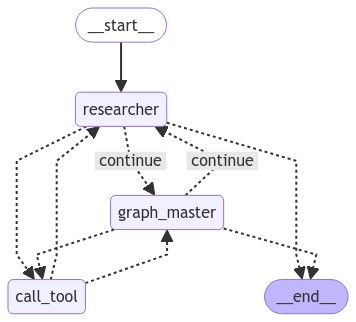

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [32]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="tell me about ben carson's relationships, make me a graph on it"

            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)

{'researcher': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_name_matches', 'arguments': '{"name": "ben carson"}'}}, response_metadata={'is_blocked': False, 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE'}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_LOW'}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE'}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE'}], 'usage_metadata': {'prompt_token_count': 2458, 'candidates_token_count': 9, 'total_token_count': 2467}}, name='researcher', id='run-fcea294e-77cb-4908-8174-6a35b80de50f-0', tool_calls=[{'name': 'get_name_matches', 'args': {'name': 'ben